# **ETL/EDA, SENTIMENT ANALYSIS** user_reviews

Aquí mostramos los pasos que hemos seguido para la limpieza, tratamiento y exploración de los datos, así como también el análisis de sentimiento en los comentarios de los reviews, el resultado de este procedimiento son 3 archivos que luego son cargados y re-procesados posteriormente en la construcción de las soluciones a los problemas planteados.

In [1]:
import pandas as pd
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz

Carga de archivo australian_user_reviews.json

In [2]:
# El siguiente codigo nos permite detectar encoding
import chardet

file_path = 'australian_user_reviews.json'

with open(file_path, 'rb') as f:
    result = chardet.detect(f.read())

encoding = result['encoding']
confidence = result['confidence']

print(f"Detected encoding: {encoding} (Confidence: {confidence:.2f})")


Detected encoding: MacRoman (Confidence: 0.70)


In [3]:
input_file = 'australian_user_reviews.json'

# Leer el contenido del archivo JSON
with open(input_file, 'r', encoding='MacRoman') as f:
    data = f.read()

# Convertir las líneas a registros JSON
records = [eval(line.strip()) for line in data.split('\n') if line.strip()]

# Crear el DataFrame a partir de los registros
dfrev = pd.DataFrame(records)

In [4]:
dfrev.head()

,user_id,user_url,reviews
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'funny': '', 'posted': 'Posted November 5, 2..."
1,js41637,http://steamcommunity.com/id/js41637,"[{'funny': '', 'posted': 'Posted June 24, 2014..."
2,evcentric,http://steamcommunity.com/id/evcentric,"[{'funny': '', 'posted': 'Posted February 3.',..."
3,doctr,http://steamcommunity.com/id/doctr,"[{'funny': '', 'posted': 'Posted October 14, 2..."
4,maplemage,http://steamcommunity.com/id/maplemage,"[{'funny': '3 people found this review funny',..."


Desempacamos Json anidados

In [5]:
desemp = [
    {**review_dict, 'user_id': row['user_id'], 'user_url': row['user_url']}
    for _, row in dfrev.iterrows()
    for review_dict in row['reviews']
] # desempacar reviews

df_reviews = pd.DataFrame(desemp)
df_reviews.head()

,funny,posted,last_edited,item_id,helpful,recommend,review,user_id,user_url
0,,"Posted November 5, 2011.",,1250,No ratings yet,True,Simple yet with great replayability. In my opi...,76561197970982479,http://steamcommunity.com/profiles/76561197970...
1,,"Posted July 15, 2011.",,22200,No ratings yet,True,It's unique and worth a playthrough.,76561197970982479,http://steamcommunity.com/profiles/76561197970...
2,,"Posted April 21, 2011.",,43110,No ratings yet,True,Great atmosphere. The gunplay can be a bit chu...,76561197970982479,http://steamcommunity.com/profiles/76561197970...
3,,"Posted June 24, 2014.",,251610,15 of 20 people (75%) found this review helpful,True,I know what you think when you see this title ...,js41637,http://steamcommunity.com/id/js41637
4,,"Posted September 8, 2013.",,227300,0 of 1 people (0%) found this review helpful,True,For a simple (it's actually not all that simpl...,js41637,http://steamcommunity.com/id/js41637


## Limpieza de los datos.

### Exploración

In [7]:
df_reviews.head()

,funny,posted,last_edited,item_id,helpful,recommend,review,user_id,user_url
0,,"Posted November 5, 2011.",,1250,No ratings yet,True,Simple yet with great replayability. In my opi...,76561197970982479,http://steamcommunity.com/profiles/76561197970...
1,,"Posted July 15, 2011.",,22200,No ratings yet,True,It's unique and worth a playthrough.,76561197970982479,http://steamcommunity.com/profiles/76561197970...
2,,"Posted April 21, 2011.",,43110,No ratings yet,True,Great atmosphere. The gunplay can be a bit chu...,76561197970982479,http://steamcommunity.com/profiles/76561197970...
3,,"Posted June 24, 2014.",,251610,15 of 20 people (75%) found this review helpful,True,I know what you think when you see this title ...,js41637,http://steamcommunity.com/id/js41637
4,,"Posted September 8, 2013.",,227300,0 of 1 people (0%) found this review helpful,True,For a simple (it's actually not all that simpl...,js41637,http://steamcommunity.com/id/js41637


Manipulamos los datos con el propósito de observar anomalías, al ordenar los datos observamos lo siguiente:
- Columna posted contiene datos sin año
- Columna review tiene emojis

In [8]:
df_reviews["review"].sort_values( inplace=False, ascending=False)

22475    üíãüíãüíãüíãüíãüíãüíãüíãüíãüíãüíãü...
29932                                 üëåüëåüëåüëåüëå
18562    üëåüëÄüëåüëÄüëåüëÄüëåüëÄüëåüëÄ good ...
2087     ùñ≥ùñæùóãùóãùñ∫ùóãùóÇùñ∫ ùñªùóéùóç ...
45777    ≈öwietna gra! Mimo, i≈º jest ciƒÖgle w fazie a...
                               ...                        
48176                                                     
4616                                                      
25300                                                     
35990                                                     
22910                                                     
Name: review, Length: 59305, dtype: object

In [9]:
df_reviews.query('index == 41908')  # hacemos una consulta para ver un dato sin año

,funny,posted,last_edited,item_id,helpful,recommend,review,user_id,user_url
41908,1 person found this review funny,Posted September 9.,Last edited September 9.,436520,16 of 18 people (89%) found this review helpful,True,This is a good but buggy game i can recommend ...,TheDarkSteveh,http://steamcommunity.com/id/TheDarkSteveh


In [10]:
df_reviews.query('index == 22475')  # hacemos una consulta para ver un review con emojis

,funny,posted,last_edited,item_id,helpful,recommend,review,user_id,user_url
22475,,"Posted October 27, 2015.",,730,0 of 1 people (0%) found this review helpful,True,üíãüíãüíãüíãüíãüíãüíãüíãüíãüíãüíãü...,76561198089779183,http://steamcommunity.com/profiles/76561198089...


Revisamos la información de la tabla

In [11]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59305 entries, 0 to 59304
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   funny        59305 non-null  object
 1   posted       59305 non-null  object
 2   last_edited  59305 non-null  object
 3   item_id      59305 non-null  object
 4   helpful      59305 non-null  object
 5   recommend    59305 non-null  bool  
 6   review       59305 non-null  object
 7   user_id      59305 non-null  object
 8   user_url     59305 non-null  object
dtypes: bool(1), object(8)
memory usage: 3.7+ MB


Conteo de nulos

In [12]:
nan_counts = df_reviews.isna().sum()

nan_counts


funny          0
posted         0
last_edited    0
item_id        0
helpful        0
recommend      0
review         0
user_id        0
user_url       0
dtype: int64

Conteo de vacíos

In [13]:
empty_counts = df_reviews.applymap(lambda x: x == '').sum()
empty_counts

funny          51154
posted             0
last_edited    53165
item_id            0
helpful            0
recommend          0
review            30
user_id            0
user_url           0
dtype: int64

Eliminamos la columna funny y last_edited debido a que no tienen datos

In [14]:
df_reviews.drop(['funny', 'last_edited'], axis=1, inplace=True)
df_reviews.head()


,posted,item_id,helpful,recommend,review,user_id,user_url
0,"Posted November 5, 2011.",1250,No ratings yet,True,Simple yet with great replayability. In my opi...,76561197970982479,http://steamcommunity.com/profiles/76561197970...
1,"Posted July 15, 2011.",22200,No ratings yet,True,It's unique and worth a playthrough.,76561197970982479,http://steamcommunity.com/profiles/76561197970...
2,"Posted April 21, 2011.",43110,No ratings yet,True,Great atmosphere. The gunplay can be a bit chu...,76561197970982479,http://steamcommunity.com/profiles/76561197970...
3,"Posted June 24, 2014.",251610,15 of 20 people (75%) found this review helpful,True,I know what you think when you see this title ...,js41637,http://steamcommunity.com/id/js41637
4,"Posted September 8, 2013.",227300,0 of 1 people (0%) found this review helpful,True,For a simple (it's actually not all that simpl...,js41637,http://steamcommunity.com/id/js41637


In [15]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59305 entries, 0 to 59304
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   posted     59305 non-null  object
 1   item_id    59305 non-null  object
 2   helpful    59305 non-null  object
 3   recommend  59305 non-null  bool  
 4   review     59305 non-null  object
 5   user_id    59305 non-null  object
 6   user_url   59305 non-null  object
dtypes: bool(1), object(6)
memory usage: 2.8+ MB


Eliminamos las filas duplicadas y reseteamos los índices

In [16]:
df_reviews.drop_duplicates(inplace=True)
df_reviews.reset_index(drop=True, inplace=True)

In [17]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58431 entries, 0 to 58430
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   posted     58431 non-null  object
 1   item_id    58431 non-null  object
 2   helpful    58431 non-null  object
 3   recommend  58431 non-null  bool  
 4   review     58431 non-null  object
 5   user_id    58431 non-null  object
 6   user_url   58431 non-null  object
dtypes: bool(1), object(6)
memory usage: 2.7+ MB


## Tratamiento de la columna 'year':

Debido a que no necesitamos la fecha completa de la columna Posted, extraemos los años y convertimos la columna a str

In [18]:
df_reviews['year'] = df_reviews['posted'].str.extract('(\d{4})', expand=False)
df_reviews['year'] = df_reviews['year'].astype('str')
df_reviews['year']=df_reviews['year'].replace('nan', pd.NA) #al convertir los años a str tuvimos que volver a declarar los valores nulos como NaN


In [19]:
nan_counts = df_reviews.isna().sum()

nan_counts

posted          0
item_id         0
helpful         0
recommend       0
review          0
user_id         0
user_url        0
year         9933
dtype: int64


Debido a que tenemos fechas sin año, vamos a seguir la estrategia de asignar un año basado en la frecuencia de los años existentes, para esto vamos a contar la frecuencia de los años, calcular su probabilidad y usaremos esa probabilidad para asignar los años a las reseñas con valores NaN

Generamos un pequeño dataFrame con años y su conteo

In [20]:
conteo_series = df_reviews.year.value_counts()

# Convertir la Serie a DataFrame
df_resultado = pd.DataFrame(conteo_series.reset_index())
df_resultado.columns = ['Año', 'Conteo']  # Renombrar las columnas si es necesario

# Ordenar por el año si lo deseas
conteo_df = df_resultado.sort_values(by='Año')

# Restablecer los índices si lo deseas
conteo_df = df_resultado.reset_index(drop=True)
conteo_df

,Año,Conteo
0,2014,21834
1,2015,18154
2,2013,6713
3,2012,1201
4,2011,530
5,2010,66


Calculamos su probabilidad y asignamos los valores de años aleatorios basados en esa probabilidad

In [21]:
# Calcular la probabilidad de cada año
conteo_df['Probabilidad'] = conteo_df['Conteo'] / conteo_df['Conteo'].sum()

# Generar un año aleatorio en función de las probabilidades
años_posibles = conteo_df['Año'].tolist()
probabilidades = conteo_df['Probabilidad'].tolist()

# Obtener índices de las filas con años NaN
indices_nan = df_reviews['year'].isna()

# Asignar años basados en las probabilidades a las filas con años NaN
df_reviews.loc[indices_nan, 'year'] = np.random.choice(años_posibles, size=indices_nan.sum(), p=probabilidades)

Verificamos que ya no hay valores Nulos

In [22]:
nan_counts = df_reviews.isna().sum()

nan_counts

posted       0
item_id      0
helpful      0
recommend    0
review       0
user_id      0
user_url     0
year         0
dtype: int64

In [23]:
df_reviews.head()

,posted,item_id,helpful,recommend,review,user_id,user_url,year
0,"Posted November 5, 2011.",1250,No ratings yet,True,Simple yet with great replayability. In my opi...,76561197970982479,http://steamcommunity.com/profiles/76561197970...,2011
1,"Posted July 15, 2011.",22200,No ratings yet,True,It's unique and worth a playthrough.,76561197970982479,http://steamcommunity.com/profiles/76561197970...,2011
2,"Posted April 21, 2011.",43110,No ratings yet,True,Great atmosphere. The gunplay can be a bit chu...,76561197970982479,http://steamcommunity.com/profiles/76561197970...,2011
3,"Posted June 24, 2014.",251610,15 of 20 people (75%) found this review helpful,True,I know what you think when you see this title ...,js41637,http://steamcommunity.com/id/js41637,2014
4,"Posted September 8, 2013.",227300,0 of 1 people (0%) found this review helpful,True,For a simple (it's actually not all that simpl...,js41637,http://steamcommunity.com/id/js41637,2013


Como información adicional podemos apreciar que la mayor cantidad de reseñas se escribieron en los años 2014 y 2015

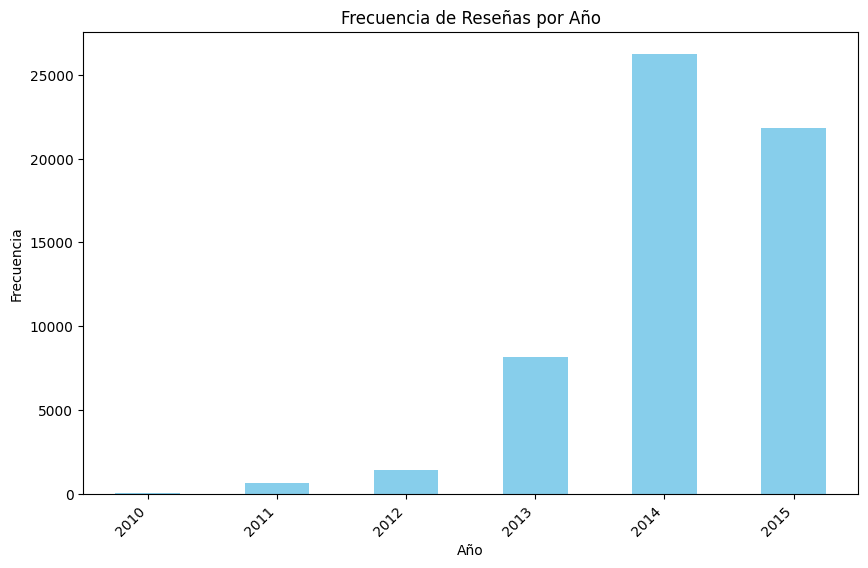

In [30]:
year_counts = df_reviews['year'].value_counts().sort_index()

# Crear un gráfico de barras ordenado de menor a mayor año
plt.figure(figsize=(10, 6))
year_counts.plot(kind='bar', color='skyblue')

# Personalizar el gráfico
plt.title('Frecuencia de Reseñas por Año')
plt.xlabel('Año')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45, ha='right')  # Rotar las etiquetas del eje x para mayor legibilidad

# Mostrar el gráfico de barras
plt.show()

### SENTIMENT ANALYSIS
En este paso desarrollaremos el analisis de sentimiento.

Como un análisis previo opcional podriamos ejecutar una detección de lenguaje en caso necesitemos realizar un análisis más complejo.

In [24]:
from langdetect import detect


# Funcion de deteccion
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'unknown'

# Aplicamos la funcion a la columna review
df_reviews['language'] = df_reviews['review'].apply(detect_language)

# Contabilizar comentarios en ingles
non_english_count = len(df_reviews[df_reviews['language'] != 'en'])

# Mostrar resultados
print("Number of non-English comments:", non_english_count)

Number of non-English comments: 13880


Ejecutamos el Sentiment Analysis sobre la columna review utilizando SentimentIntensityAnalyzer de NLTK

In [25]:

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

# Inicializamos
sid = SentimentIntensityAnalyzer()

# Ejecutamos el analisis en la columna review y creamos la columna sent_an con los resultados
df_reviews['sentiment_score'] = df_reviews['review'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Categorizamos los scores
df_reviews['sent_an'] = df_reviews['sentiment_score'].apply(lambda x: 2 if x > 0.05 else (1 if -0.05 <= x <= 0.05 else 0))

# Eliminamos la columna auxiliar
df_reviews.drop('sentiment_score', axis=1, inplace=True)



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Visualizamos gráficamente los resultados para tener mayor entendimiento de los datos

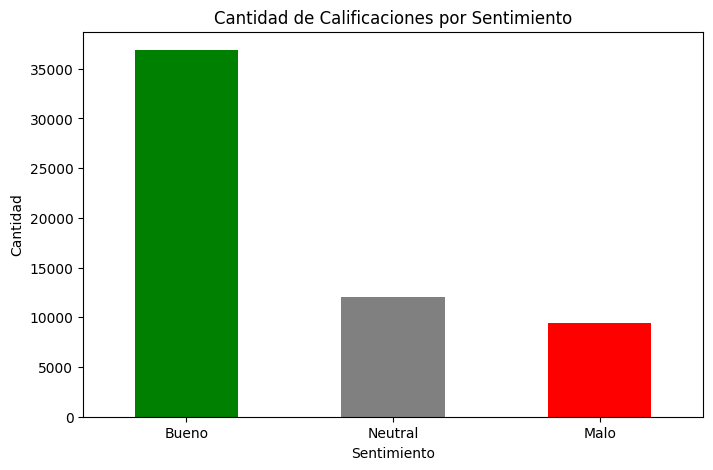

In [29]:
df_reviews['sentiment'] = df_reviews['sent_an'].map({2: 'Bueno', 1: 'Neutral', 0: 'Malo'})

# Contar la cantidad de calificaciones por categoría
sentiment_counts = df_reviews['sentiment'].value_counts()

# Crear un gráfico de barras
plt.figure(figsize=(8, 5))
sentiment_counts.plot(kind='bar', color=['green', 'gray', 'red'])

# Personalizar el gráfico
plt.title('Cantidad de Calificaciones por Sentimiento')
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad')
plt.xticks(rotation=0)  # No rotar las etiquetas del eje x

# Mostrar el gráfico de barras
plt.show()

In [26]:
df_reviews.head()

,posted,item_id,helpful,recommend,review,user_id,user_url,year,language,sent_an
0,"Posted November 5, 2011.",1250,No ratings yet,True,Simple yet with great replayability. In my opi...,76561197970982479,http://steamcommunity.com/profiles/76561197970...,2011,en,2
1,"Posted July 15, 2011.",22200,No ratings yet,True,It's unique and worth a playthrough.,76561197970982479,http://steamcommunity.com/profiles/76561197970...,2011,en,2
2,"Posted April 21, 2011.",43110,No ratings yet,True,Great atmosphere. The gunplay can be a bit chu...,76561197970982479,http://steamcommunity.com/profiles/76561197970...,2011,en,2
3,"Posted June 24, 2014.",251610,15 of 20 people (75%) found this review helpful,True,I know what you think when you see this title ...,js41637,http://steamcommunity.com/id/js41637,2014,en,2
4,"Posted September 8, 2013.",227300,0 of 1 people (0%) found this review helpful,True,For a simple (it's actually not all that simpl...,js41637,http://steamcommunity.com/id/js41637,2013,en,2


In [27]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58431 entries, 0 to 58430
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   posted     58431 non-null  object
 1   item_id    58431 non-null  object
 2   helpful    58431 non-null  object
 3   recommend  58431 non-null  bool  
 4   review     58431 non-null  object
 5   user_id    58431 non-null  object
 6   user_url   58431 non-null  object
 7   year       58431 non-null  object
 8   language   58431 non-null  object
 9   sent_an    58431 non-null  int64 
dtypes: bool(1), int64(1), object(8)
memory usage: 4.1+ MB


Lo cargamos en un csv para poder utilizarlo en procesos posteriores.

In [28]:
df_reviews.to_csv('reviews90p.csv')